# Imports

In [1]:
# we will need these
import numpy as np
import matplotlib.pyplot as plt
import lmfit

In [2]:
%matplotlib inline

# Definitions

In [3]:
def read_time_res(fname):
    """Read the time resolution from file."""
    with open(fname) as f:
        for i in range(8):
            f.readline()
        d = f.readline()
    return np.array([float(element) for element in d.strip().split()])

def read_data(fname):
    """Load the counts from file."""
    return np.loadtxt(fname, dtype=int, skiprows=10)

# Load and check data

In [4]:
fname = "palato_260421_1.dat"
data = read_data(fname)[:,3:5] # load columns 3 and 4
data

array([[9, 3],
       [5, 3],
       [1, 0],
       ...,
       [0, 0],
       [0, 0],
       [0, 0]])

Our `data` variable now contains a the counts in a 2D table. Above we see an abbreviated version of it, the complete array is very long. We can check its shape, as `(rows, columns)`.

In [5]:
print(data.shape) # we have 32768 rows and 2 columns

(32768, 2)


We can select elements from the data. The first index corresponds to rows, the second index corresponds to columns. `python` indexes starting with 0, so the first column is column 0, the second column is column 1, etc.

To specify a range, we can write `variable[start:stop:step]`. The section `start:stop:step` is called a `slice`. `stop` is excluded. We can ask for one slice per axis. If `start` or `stop` are missing, it means "from start" or "until the end". If `step` is ommited, it defaults to 1.

The following line will print elements at index `5,7,9` from column number 1. Remember that column number 1 is the second column!

In [6]:
data[5:10:2, 1]  # this reads as: select rows 5 to 10 by steps of 2, and second column.

array([  19,    1, 1408])

To select a single column, we do:

In [7]:
data[:,1]

array([3, 3, 0, ..., 0, 0, 0])

We can check the time delay per bin, in ns per bin.

In [8]:
time_per_bin = read_time_res(fname)[3:5]
print(time_per_bin)

[0.1 0.1]


It's the same in both cases, so we just keep one value.

In [9]:
dt = time_per_bin[0]
print(dt)

0.1


Our time delays are:

In [10]:
times = np.arange(data.shape[0])*dt
times

array([0.0000e+00, 1.0000e-01, 2.0000e-01, ..., 3.2765e+03, 3.2766e+03,
       3.2767e+03])

# Data inspection

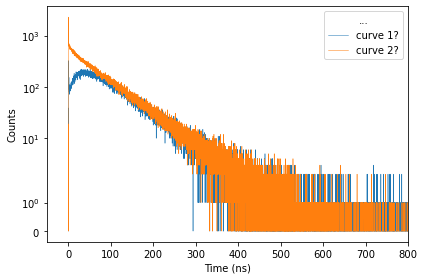

In [11]:
plt.figure() # create a figure. We can specify the size, resolution, etc, here.
# we can control the style here, if we don't like the defaults. `lw` stands for `linewidth`.
plt.plot(times, data[:,0], lw=0.5, label="curve 1?") 
plt.plot(times, data[:,1], lw=0.5, label="curve 2?") 
plt.yscale("symlog") # use the "symlog" scale along y. 
# "symlog" uses a log scale for the y axis, except for values around 0, where a linear scale is used
plt.xlim(-50, 800) # set the x limits of the plot
plt.ylabel("Counts")
plt.xlabel("Time (ns)")
# A a legend. The simplest way is to pass a label for every call to `plot`, and just let the legend build itself.
plt.legend(title="...")
plt.tight_layout() # it's better

There is something off in the early part. You should be able to zoom in on the early part using the controls of the interactive plot. Otherwise, we can change the limits manually as such:

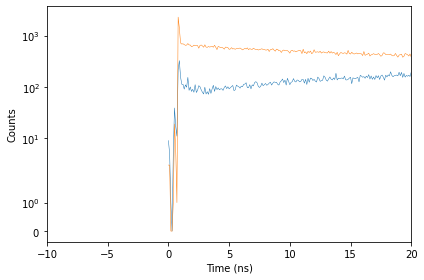

In [12]:
plt.figure()
plt.plot(times, data[:,0], lw=0.5, label="curve 1?") 
plt.plot(times, data[:,1], lw=0.5, label="curve 2?") 
plt.yscale("symlog") 
plt.xlim(-10, 20) # set the x limits of the plot
plt.ylabel("Counts")
plt.xlabel("Time (ns)")
# A a legend. The simplest way is to pass a label for every call to `plot`, and just let the legend build itself.
plt.tight_layout() # it's better

Suscpicious... Keep in mind this is on log scale, so that early spike is actually very large. In linear scale, it looks like this:

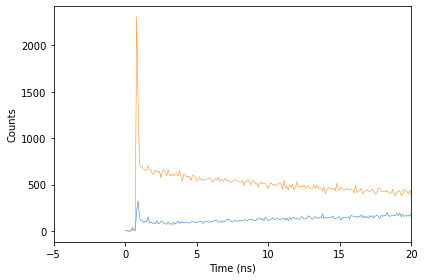

In [13]:
plt.figure() 
plt.plot(times, data[:,0], lw=0.5, label="curve 1?") 
plt.plot(times, data[:,1], lw=0.5, label="curve 2?") 
plt.xlim(-5, 20) # set the x limits of the plot
plt.ylabel("Counts")
plt.xlabel("Time (ns)")
plt.tight_layout() # it's better

It seems the IRF is leaking through. We should investigate this more carefully. In the meantime, we can estimate $t_0$ to about 0.8 ns. We should also remove the weird early part from the analysis. Let's define a lower time limit at 5 ns, and remove everything else.

In [14]:
t0 = 0.8
limit_low = 5

The array `is_valid` contains `True` or `False`, depending on our lower time limit. 

In [15]:
is_valid = times > limit_low
is_valid

array([False, False, False, ...,  True,  True,  True])

The method `compress` will remove regions where `is_valid` is `False`, therefore eliminating the early part.

In [16]:
is_valid = times > limit_low # i'm repeating this to avoid errors after multiple executions.
times = np.compress(is_valid, times)
# data is 2D, so we need to say if we want to operate along rows (axis 0) or columns (axis 1)
data = np.compress(is_valid, data, axis=0) 

By showing the graph again, we can see the early part has been eliminated. I want to emphasize that fixing data like this should be avoided as much as possible. Performing a better experiment is infinitely superior.

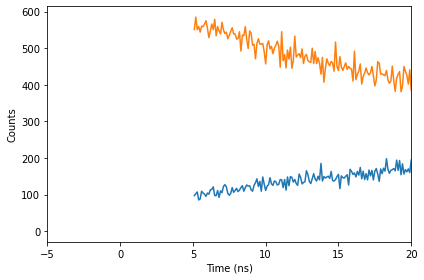

In [17]:
plt.figure() 
plt.plot(times, data[:,0], label="curve 1?") 
plt.plot(times, data[:,1], label="curve 2?") 
plt.xlim(-5, 20) 
plt.ylabel("Counts")
plt.xlabel("Time (ns)")
plt.tight_layout()

# Onto fitting

Non-linear least-squares curve fits try to fit (ie: adjust) a curve to the data by finding the best parameters for the curve. Scientifically, we need to have a model for how our observations (eg: counts $I$) depend on the independent variable (eg: time $t$). In the case of chemical kinetics and fluorescence lifetime in particular, this is often a sum of expontential decays. We therefore have, for example:
$$
y_\mathrm{fit}(t) = a_0e^{-t/\tau_0}
$$
In this case, the fitting routine will try to find the values of $a_0$, $\tau_0$. Note that $I_\mathrm{fit}(t)$ depends linearly on $a_0$, but depends non-linearly on $\tau_0$ ($\tau_0$ is in the exponential). The nonlinear dependance of the parameters requires the use of nonlinear fitting routines.

The fitting routine will find the values of ($a_0$, $\tau_0$) which result in the best correspondance between the observations $y_\mathrm{obs}$ and the fitted values $y_\mathrm{fit}$. The most common choice is to minimize the sum of the squared residuals, weighted by the uncertainties $\epsilon_i$:
$$
\chi^2 = \sum_i \frac{\left(y_{\mathrm{obs},i}-y_{\mathrm{fit},i}\right)^2}{\epsilon_i}
$$
where the index $i$ runs over data points. $\chi^2$ is called the objective function, it's minimum should give us the best result. Note that other choices of objective functions are possible, but this is the most common.

The role of the fitting algorithm is therefore to systematically vary the parameters in order to find the values that minimize $\chi^2$. In principle, you could do this by hand (if you are very patient), but that sort of tedious detailed work is best left to computers.

There are mulitple methods to vary the parameters. In most cases, they should be starting from a decent "initial guess", and the algorithm will systematically adjust the parameters in search of the minimum.

*Initial guess*

*bounds*

*note on constraints*


Luckily, we are not the first ones to try a non-linear least squares. Indeed, this is a active area of research, and a common task across science and engineering. Here, we will use a module called `lmfit`. This module lets us define our own custom fit functions, and takes care of how to make this compatible with existing non-linear curve fitting routines.

Here, we will define our own fit function, and use `lmfit` to carry out the fitting.

In [18]:
def single_exp(x, a0, tau0, t0): # we can use any variable for the independant variable, but `x` is the default.
    xr = x-t0
    y = np.zeros_like(x) # an array full of 0, same shape as x
    y[x > t0] = a0*np.exp(-xr/tau0)
    return y

We now try our model, and see how a guess compares to the data.

(-50.0, 800.0)

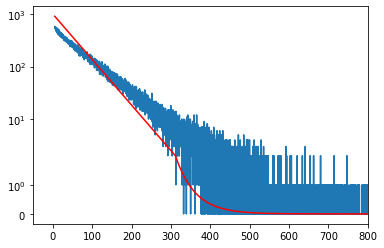

In [19]:
guessed_data = single_exp(times, 1E3, 50, t0)

plt.figure()
plt.plot(times, data[:,1], label="curve 1?") 
plt.plot(times, guessed_data, color="r") # red!
plt.yscale("symlog")
plt.xlim(-50, 800)

It could clearly be better, but for such a simple model that's good enough. We can feed our model to `lmfit`, setup an inital guess and add some bounds to our data.

Here we create the `Model` object, and create a set of initial parameters called `guess`. We can see that the code has correctly understood our function has 3 parameters, called `a0`, `tau0` and `t0`.

In [20]:
model = lmfit.Model(single_exp) # some programming magic happens here...
guess = model.make_params()
guess

name,value,initial value,min,max,vary
a0,-inf,None,-inf,inf,True
tau0,-inf,None,-inf,inf,True
t0,-inf,None,-inf,inf,True


We now set up the initial guess, using the values we tried above. We also set minimum bounds to `a0` and `tau0`, so they cannot be negative. Such critera of course depend on the specific problem.

 Varying `t0` would also be a problem in this specific case. In order to let the fitting algorithm adjust it, we would need to take the IRF into account. Luckily, our dynamics occur on timescales which are way longer, so it has no impact. We set the value of `t0` to the value we determined earlier, and don't vary it.

In [21]:
guess["a0"].set(value=1E3, min=0) # initial value, same as above, minimum value=0
guess["tau0"].set(value=50, min=0)
guess["t0"].set(value=t0, vary=False) # varying the value of t0 will not work in this case; we keep it frozen 
guess

name,value,initial value,min,max,vary
a0,1000.00000,None,0.00000000,inf,True
tau0,50.0000000,None,0.00000000,inf,True
t0,0.80000000,None,-inf,inf,False


Good, now we fit.

In [22]:
result = model.fit(data[:,1], guess, x=times)
result

(-50.0, 800.0)

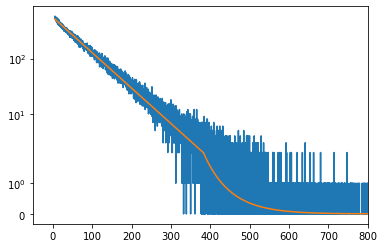

In [23]:
plt.figure()
plt.plot(times, data[:,1])
plt.plot(times, result.best_fit)
plt.yscale("symlog")
plt.xlim(-50, 800)

In [24]:
eps=1E-9

In [25]:
result = model.fit(data[:,1], guess, x=times, method="nedler", )
result

(-50.0, 800.0)

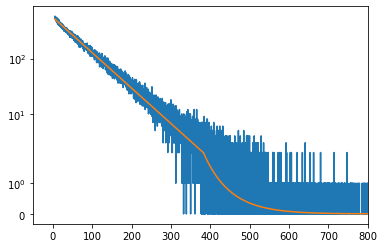

In [26]:
plt.figure()
plt.plot(times, data[:,1])
plt.plot(times, result.best_fit)
plt.yscale("symlog")
plt.xlim(-50, 800)

(-50.0, 300.0)

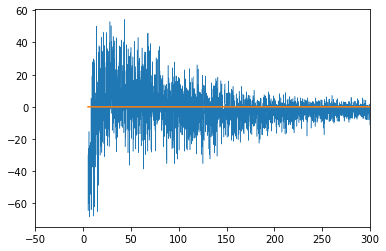

In [27]:
plt.figure()
plt.plot(times, result.residual, lw=0.5)
plt.plot(times, np.zeros_like(times))
plt.xlim(-50, 300)

In [28]:
def double_exp(x, a0, a1, tau0, tau1, t0): # we can use any variable for the independant variable, but `x` is the default.
    xr = x-t0
    y = np.zeros_like(x) # an array full of 0, same shape as x
    y[x > t0] = a0*np.exp(-xr/tau0)+a1*np.exp(-xr/tau1)
    return y

model = lmfit.Model(double_exp) # some programming magic happens here...
guess = model.make_params()
guess["a0"].set(value=1E2) # initial value, same as above, minimum value=0
guess["tau0"].set(value=100, min=20)
guess["a1"].set(value=1E2) # initial value, same as above, minimum value=0
guess["tau1"].set(value=10, min=0.1)
guess["t0"].set(value=t0, vary=False) # varying the value of t0 will not work in this case; we keep it frozen 



In [29]:
result = model.fit(data[:,1], guess, x=times)
result

(-50.0, 800.0)

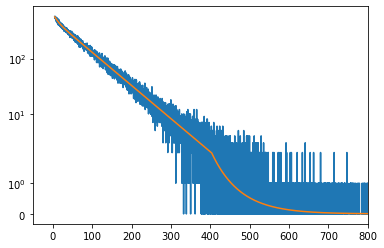

In [30]:
plt.figure()
plt.plot(times, data[:,1])
plt.plot(times, result.best_fit)
plt.yscale("symlog")
plt.xlim(-50, 800)

(-50.0, 300.0)

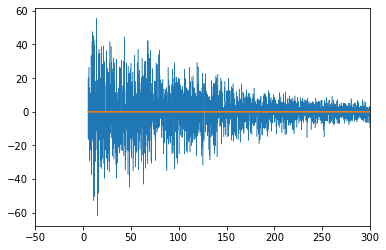

In [31]:
plt.figure()
plt.plot(times, result.residual, lw=0.5)
plt.plot(times, np.zeros_like(times))
plt.xlim(-50, 300)

In [32]:
guess = model.make_params()
guess["a0"].set(value=1E2) # initial value, same as above, minimum value=0
guess["tau0"].set(value=100, min=20)
guess["a1"].set(value=-1E2) # initial value, same as above, minimum value=0
guess["tau1"].set(value=10, min=0.1)
guess["t0"].set(value=t0, vary=False) # varying the value of t0 will not work in this case; we keep it frozen 

result = model.fit(data[:,0], guess, x=times, method="nedler")
result

(-50.0, 800.0)

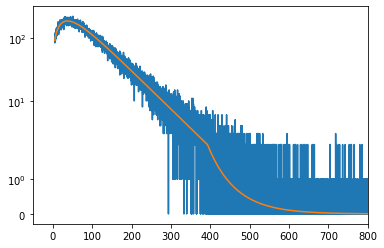

In [33]:
plt.figure()
plt.plot(times, data[:,0])
plt.plot(times, result.best_fit)
plt.yscale("symlog")
plt.xlim(-50, 800)